In [45]:
%matplotlib inline
from IPython.display import Image
import numpy as np
import matplotlib.pyplot as plt
import openmc
import os

os.environ['OPENMC_CROSS_SECTIONS'] = '/home/sebas/Documents/Code/jupyter/endfb-viii.0-hdf5/cross_sections.xml'

In [46]:
# 1.6 enriched fuel
fuel = openmc.Material(name='1.6% Fuel')
fuel.set_density('g/cm3', 10.31341)
fuel.add_nuclide('U235', 3.7503e-4)
fuel.add_nuclide('U238', 2.2625e-2)
fuel.add_nuclide('O16', 4.6007e-2)

# borated water
water = openmc.Material(name='Borated Water')
water.set_density('g/cm3', 0.740582)
water.add_nuclide('H1', 4.9457e-2)
water.add_nuclide('O16', 2.4732e-2)
water.add_nuclide('B10', 8.0042e-6)

# zircaloy
zircaloy = openmc.Material(name='Zircaloy')
zircaloy.set_density('g/cm3', 6.55)
zircaloy.add_nuclide('Zr90', 7.2758e-3)

In [47]:
# Instantiate a Materials collection
materials = openmc.Materials([fuel, water, zircaloy])

# Export to "materials.xml"
materials.export_to_xml()

In [48]:
# Create cylinders for the fuel and clad
fuel_outer_radius = openmc.ZCylinder(x0=0.0, y0=0.0, r=0.39218)
clad_outer_radius = openmc.ZCylinder(x0=0.0, y0=0.0, r=0.45720)

# Create boundary planes to surround the geometry
min_x = openmc.XPlane(x0=-0.63, boundary_type='reflective')
max_x = openmc.XPlane(x0=+0.63, boundary_type='reflective')
min_y = openmc.YPlane(y0=-0.63, boundary_type='reflective')
max_y = openmc.YPlane(y0=+0.63, boundary_type='reflective')
min_z = openmc.ZPlane(z0=-0.63, boundary_type='reflective')
max_z = openmc.ZPlane(z0=+0.63, boundary_type='reflective')

In [49]:
# Create a Universe to encapsulate a fuel pin
pin_cell_universe = openmc.Universe(name='1.6% Fuel Pin')

# Create fuel Cell
fuel_cell = openmc.Cell(name='1.6% Fuel')
fuel_cell.fill = fuel
fuel_cell.region = -fuel_outer_radius
pin_cell_universe.add_cell(fuel_cell)

# Create a clad Cell
clad_cell = openmc.Cell(name='1.6% Clad')
clad_cell.fill = zircaloy
clad_cell.region = +fuel_outer_radius & -clad_outer_radius
pin_cell_universe.add_cell(clad_cell)

# Create a moderator Cell
moderator_cell = openmc.Cell(name='1.6% Moderator')
moderator_cell.fill = water
moderator_cell.region = +clad_outer_radius
pin_cell_universe.add_cell(moderator_cell)

In [50]:
# Create root Cell
root_cell = openmc.Cell(name='root cell')
root_cell.fill = pin_cell_universe

# Add boundary planes
root_cell.region = +min_x & -max_x & +min_y & -max_y & +min_z & -max_z

# Create root Universe
root_universe = openmc.Universe(universe_id=0, name='root universe')
root_universe.add_cell(root_cell)

/home/sebas/miniconda3/envs/openmc-env/lib/python3.12/site-packages/openmc/mixin.py:70: IDWarning: Another UniverseBase instance already exists with id=0.
  warn(msg, IDWarning)


In [51]:
# Create Geometry and set root Universe
geometry = openmc.Geometry(root_universe)

In [52]:
# Export to "geometry.xml"
geometry.export_to_xml()

In [53]:
# OpenMC simulation parameters
settings = openmc.Settings()
settings.batches = 100
settings.inactive = 10
settings.particles = 5000

# Create an initial uniform spatial source distribution over fissionable zones
bounds = [-0.63, -0.63, -0.63, 0.63, 0.63, 0.63]
uniform_dist = openmc.stats.Box(bounds[:3], bounds[3:], only_fissionable=True)
settings.source = openmc.IndependentSource(space=uniform_dist)

# Export to "settings.xml"
settings.export_to_xml()

/home/sebas/miniconda3/envs/openmc-env/lib/python3.12/site-packages/openmc/stats/multivariate.py:829: FutureWarning: The 'only_fissionable' has been deprecated. Use the 'constraints' argument when defining a source instead.
  warn("The 'only_fissionable' has been deprecated. Use the "


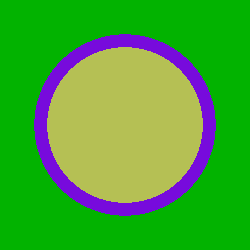

In [54]:
plot = openmc.Plot.from_geometry(geometry)
plot.pixels = (250, 250)
plot.to_ipython_image()

In [55]:
# Instantiate an empty Tallies object
tallies = openmc.Tallies()

In [56]:
# Create mesh which will be used for tally
mesh = openmc.RegularMesh()
mesh.dimension = [100, 100]
mesh.lower_left = [-0.63, -0.63]
mesh.upper_right = [0.63, 0.63]

# Create mesh filter for tally
mesh_filter = openmc.MeshFilter(mesh)

# Create mesh tally to score flux and fission rate
tally = openmc.Tally(name='flux')
tally.filters = [mesh_filter]
tally.scores = ['flux', 'fission']
tallies.append(tally)

In [57]:
# Export to "tallies.xml"
tallies.export_to_xml()

In [58]:
# Run OpenMC!
openmc.run()

[sebastian-TUF-Gaming-FX505GT:172723] shmem: mmap: an error occurred while determining whether or not /tmp/ompi.sebastian-TUF-Gaming-FX505GT.1000/jf.0/2694971392/shared_mem_cuda_pool.sebastian-TUF-Gaming-FX505GT could be created.
[sebastian-TUF-Gaming-FX505GT:172723] create_and_attach: unable to create shared memory BTL coordinating structure :: size 134217728 
                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%

In [59]:
# Load the statepoint file
sp = openmc.StatePoint('statepoint.100.h5')

In [60]:
tally = sp.get_tally(scores=['flux'])
print(tally)

Tally
	ID             =	5
	Name           =	flux
	Filters        =	MeshFilter
	Nuclides       =	total
	Scores         =	['flux', 'fission']
	Estimator      =	tracklength
	Multiply dens. =	True


In [61]:
tally.sum

array([[[0.40741859, 0.        ]],

       [[0.40892588, 0.        ]],

       [[0.407783  , 0.        ]],

       ...,

       [[0.40987344, 0.        ]],

       [[0.41024243, 0.        ]],

       [[0.41195757, 0.        ]]])

In [62]:
print(tally.mean.shape)
(tally.mean, tally.std_dev)

(10000, 1, 2)


(array([[[0.00452687, 0.        ]],
 
        [[0.00454362, 0.        ]],
 
        [[0.00453092, 0.        ]],
 
        ...,
 
        [[0.00455415, 0.        ]],
 
        [[0.00455825, 0.        ]],
 
        [[0.00457731, 0.        ]]]),
 array([[[1.93656600e-05, 0.00000000e+00]],
 
        [[1.68918159e-05, 0.00000000e+00]],
 
        [[1.91757811e-05, 0.00000000e+00]],
 
        ...,
 
        [[1.88026621e-05, 0.00000000e+00]],
 
        [[1.76879034e-05, 0.00000000e+00]],
 
        [[1.67689172e-05, 0.00000000e+00]]]))

In [63]:
flux = tally.get_slice(scores=['flux'])
fission = tally.get_slice(scores=['fission'])
print(flux)

Tally
	ID             =	6
	Name           =	flux
	Filters        =	MeshFilter
	Nuclides       =	total
	Scores         =	['flux']
	Estimator      =	tracklength
	Multiply dens. =	True


In [64]:
flux.std_dev.shape = (100, 100)
flux.mean.shape = (100, 100)
fission.std_dev.shape = (100, 100)
fission.mean.shape = (100, 100)

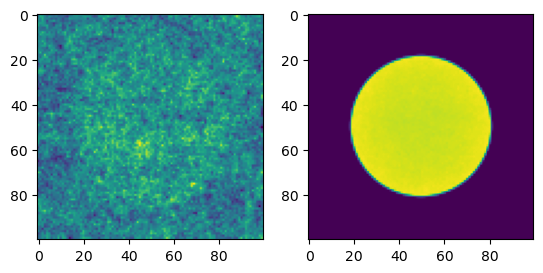

In [65]:
fig = plt.subplot(121)
fig.imshow(flux.mean)
fig2 = plt.subplot(122)
fig2.imshow(fission.mean)

In [66]:
# Determine relative error
relative_error = np.zeros_like(flux.std_dev)
nonzero = flux.mean > 0
relative_error[nonzero] = flux.std_dev[nonzero] / flux.mean[nonzero]

# distribution of relative errors
ret = plt.hist(relative_error[nonzero], bins=50)sp.source

SyntaxError: invalid syntax (2734766110.py, line 7)

In [67]:
sp.source

array([((-0.10394171,  0.12421026, -0.55177457), (-0.59970907, -0.63707182, -0.48424015),  636895.0955969 , 0.003085  , 1., 0, 0, 0),
       ((-0.10394171,  0.12421026, -0.55177457), ( 0.72065057,  0.14814852, -0.67728485),  278472.30548722, 0.003085  , 1., 0, 0, 0),
       ((-0.293687  ,  0.08447675, -0.58670663), ( 0.18526195,  0.12879812, -0.97421202),  954348.03754375, 0.00334094, 1., 0, 0, 0),
       ...,
       (( 0.1690462 , -0.18771659,  0.23867456), ( 0.19579826, -0.21691101, -0.95635383),  549217.91921249, 0.00374685, 1., 0, 0, 0),
       ((-0.37755825,  0.07781125,  0.38522377), ( 0.89917712, -0.37139161,  0.23140608), 1306658.85382747, 0.00362718, 1., 0, 0, 0),
       ((-0.37755825,  0.07781125,  0.38522377), (-0.55993972,  0.67342729, -0.48266261),  854628.53945146, 0.00362718, 1., 0, 0, 0)],
      dtype={'names': ['r', 'u', 'E', 'time', 'wgt', 'delayed_group', 'surf_id', 'particle'], 'formats': [[('x', '<f8'), ('y', '<f8'), ('z', '<f8')], [('x', '<f8'), ('y', '<f8'), ('z'

In [68]:
sp.source['E']

array([ 636895.0955969 ,  278472.30548722,  954348.03754375, ...,
        549217.91921249, 1306658.85382747,  854628.53945146])

0.9999999999999999


Text(0, 0.5, 'Probability/eV')

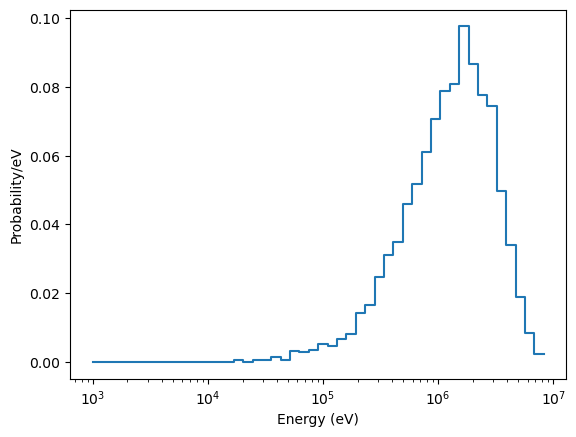

In [69]:
# Create log-spaced energy bins from 1 keV to 10 MeV
energy_bins = np.logspace(3,7)

# Calculate pdf for source energies
probability, bin_edges = np.histogram(sp.source['E'], energy_bins, density=True)

# Make sure integrating the PDF gives us unity
print(sum(probability*np.diff(energy_bins)))

# Plot source energy PDF
plt.semilogx(energy_bins[:-1], probability*np.diff(energy_bins), drawstyle='steps')
plt.xlabel('Energy (eV)')
plt.ylabel('Probability/eV')

(-0.5, 0.5)

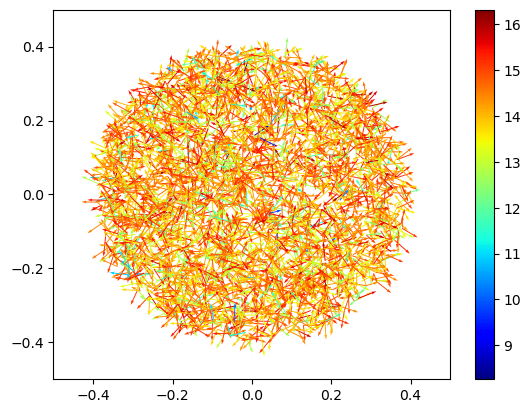

In [70]:
plt.quiver(sp.source['r']['x'], sp.source['r']['y'],
           sp.source['u']['x'], sp.source['u']['y'],
           np.log(sp.source['E']), cmap='jet', scale=20.0)
plt.colorbar()
plt.xlim((-0.5,0.5))
plt.ylim((-0.5,0.5))

In [71]:
# Close the statepoint file as a matter of best practice
sp.close()